Imports

In [1]:
import torch
import torch.nn as nn
import tifffile
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

Max pooling: understanding the principle

In [2]:


# Définir une couche d'entrée avec une dimension de (batch_size, channels, height, width)
input_layer = torch.rand(1, 1, 4, 4)
print(input_layer)

# Utiliser la couche MaxPool2d avec une fenêtre de pooling de 2x2
max_pool_layer = nn.AvgPool2d(kernel_size=2, stride=2)

# Appliquer le max pooling à la couche d'entrée
output = max_pool_layer(input_layer)
print(output)

# Afficher les résultats
print("Input shape:", input_layer.shape)
print("Output shape:", output.shape)


tensor([[[[0.1616, 0.3727, 0.4367, 0.2553],
          [0.3650, 0.4181, 0.3120, 0.6841],
          [0.4614, 0.9191, 0.9739, 0.2567],
          [0.1942, 0.1148, 0.1161, 0.8990]]]])
tensor([[[[0.3294, 0.4220],
          [0.4224, 0.5614]]]])
Input shape: torch.Size([1, 1, 4, 4])
Output shape: torch.Size([1, 1, 2, 2])


Printing tif images

data/masks/M-33-20-D-c-4-2_231.tif
Dimensions de l'image : (9636, 9095)
Type de données de l'image : uint8


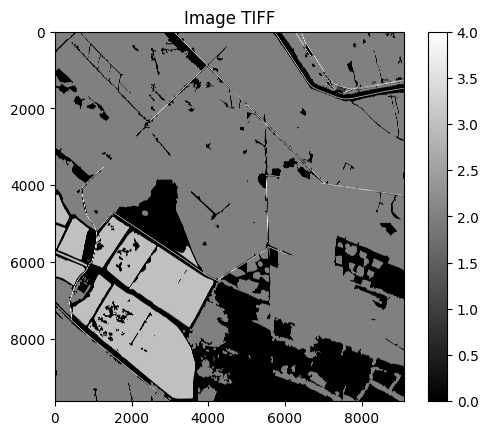

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], dtype=uint8)

In [3]:

folder_path = "data/masks/"
# Spécifiez le chemin vers votre fichier TIFF
tif_path = folder_path+"M-33-20-D-c-4-2.tif" #folder_path + os.listdir(folder_path)[0]
print(folder_path+"M-33-20-D-c-4-2_231.tif")



# Chargez l'image TIFF avec PIL
image = Image.open(tif_path)
image_array = plt.imread(tif_path)

# Affichez les dimensions de l'image et son type de données
print("Dimensions de l'image :", image_array.shape)
print("Type de données de l'image :", image_array.dtype)

# Affichez l'image
plt.imshow(image_array, cmap='gray')  # Vous pouvez ajuster la colormap en fonction de votre image
plt.title("Image TIFF")
plt.colorbar()
plt.show()

image_array[8000:8010,6000:6010]

Open a png image

In [4]:

folder_path = "data/output/"
# Spécifiez le chemin vers votre fichier TIFF
png_path = folder_path + os.listdir(folder_path)[100]
print(png_path)

# Chargez l'image TIFF avec PIL
image = Image.open(png_path)
image_array = plt.imread(png_path)

print(image_array.shape)
print(np.sum(image_array, axis=2)/3)
# Affichez l'image
plt.imshow(np.sum(image_array, axis=2)/3, cmap='gray')  # Vous pouvez ajuster la colormap en fonction de votre image
plt.title("Image")
plt.colorbar()
plt.show()

IndexError: list index out of range

Entrainement avec une image

cpu
False


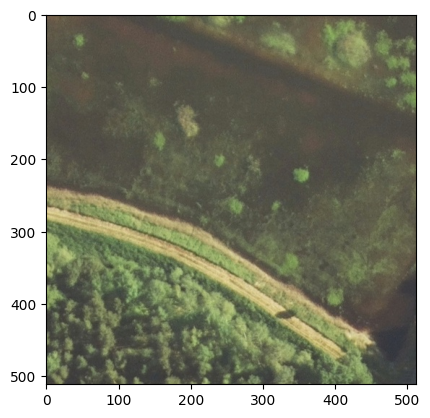

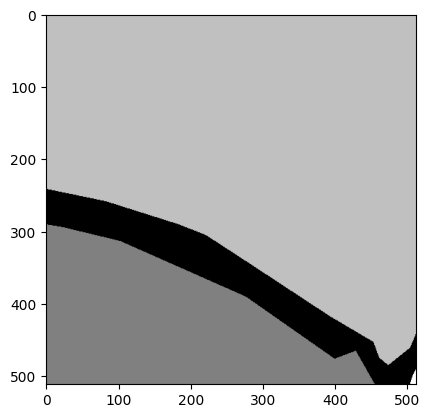

input_data: torch.Size([1, 3, 512, 512])
label_data: torch.Size([1, 5, 512, 512])
outputs: torch.Size([1, 5, 512, 512])


KeyboardInterrupt: 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tifffile

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Définir l'architecture U-Net simplifiée
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Dimensions de l'image en entrée et du nombre de classes
input_channels = 3  # 3 canaux pour une image RGB
output_channels = 5  # ajustez en fonction du nombre de classes de couvert terrestre que vous avez

# Créer le modèle U-Net
unet_model = UNet(input_channels, output_channels)
unet_model.to(device=device)
print(torch.cuda.is_available())

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

# Charger les données d'entraînement (remplacez cela par vos propres chemins de fichiers)
input_tiff_path = "data/output/images/M-33-20-D-c-4-2_216.tif"
label_tiff_path = "data/output/masks/M-33-20-D-c-4-2_216.tif"

# Charger les images TIFF
input_data = torch.from_numpy(plt.imread(input_tiff_path)).float()
plt.imshow(input_data/255, cmap='gray')  # Vous pouvez ajuster la colormap en fonction de votre image
plt.show()
label_data = torch.from_numpy(plt.imread(label_tiff_path)[:,:,0]).long()
plt.imshow(label_data, cmap='gray')  # Vous pouvez ajuster la colormap en fonction de votre image
plt.show()
label_data = F.one_hot(label_data, num_classes=output_channels).unsqueeze(0).permute(0, 3, 1, 2).float()
input_data = input_data.unsqueeze(0).permute(0, 3, 1, 2)
print("input_data:",input_data.shape)
print("label_data:",label_data.shape)


# Entraînement du modèle
epochs = 200
for epoch in range(epochs):
    # Forward pass
    outputs = unet_model(input_data)

    # Appliquer la fonction softmax pour obtenir des probabilités
    probs = F.softmax(outputs, dim=1)

    # Obtenir la classe prédite pour chaque pixel
    _, predicted_class = torch.max(probs, dim=1)

    # Créer une image one-hot encoding à partir des classes prédites
    predicted_one_hot = F.one_hot(predicted_class, num_classes=output_channels)

    # Calcul de la perte
    print("outputs:",outputs.shape)
    loss = criterion(outputs, label_data)

    # Rétropropagation et mise à jour des poids
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Affichage de la perte à chaque époque
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Pour l'inference (prédiction), utilisez le modèle entraîné avec de nouvelles données.
# Exemple : new_outputs = unet_model(new_input_data)

probs = F.softmax(outputs, dim=1)

# Obtenir la classe prédite pour chaque pixel
_, predicted_class = torch.max(probs, dim=1)

# Créer une image one-hot encoding à partir des classes prédites
predicted_one_hot = F.one_hot(predicted_class, num_classes=output_channels)
# Convertir Tensor en NumPy array pour faciliter la manipulation
predicted_class_np = predicted_class.cpu().numpy()

# Afficher l'image de classification
plt.imshow(predicted_class_np[0], cmap='gray', vmin=0, vmax=4)  # Ajustez la colormap selon vos besoins
plt.show()
